In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
pd.set_option("display.max_rows", None)

In [2]:
#creating a function to find SMA for n period 
def sma(data,period):
      return data.rolling(period).mean()

In [3]:
# start='2023-06-20'
# end='2023-08-12'
# data=yf.download("CL=F", start, end, interval="30m")

In [4]:
symbol = 'CL=F'
start = '2023-06-20'
end = '2023-08-14'
data=yf.download(symbol,start,end, interval="15m")

[*********************100%***********************]  1 of 1 completed


In [5]:
#function to find RSI of n period 
def rsi(data,period): 
    change = data.diff(1)
    gain = change.mask(change<0,0)
    loss = abs(change.mask(change>0,0))
    avg_gain = gain.rolling(period).mean()
    avg_loss= loss.rolling(period).mean()
    rs = avg_gain/avg_loss
    return ( 100 - (100/(1+rs)))

In [6]:
def slope(x,y): 
    dif=x-y
    if dif>=0: 
        return False
    else: 
        return True
    

In [7]:
data["RSI"]=rsi(data["Close"], 7)
data["SMA3"]=sma(data["Close"],3)
data["SMA20"]=sma(data["Close"],20)
data["SMA5"]=sma(data["Close"],5)
data["entry_long"]=""
data["exit_long"]=""
data["entry_short"]=""
data["exit_short"]=""
data["stop_loss"]=""
data["target"]=""
data["trade_type"]=""
global no_trade
no_trade=0
p_l_short=[]
p_l_long=[]
p_l=[]

In [10]:


# Initialize trade variables
in_long_trade = False
in_short_trade = False

# Iterate through the data
for i in range(1, len(data)):
    # Long trade entry conditions
    if data['Close'][i] > data['SMA20'][i] and data['SMA3'][i] > data['SMA5'][i] and data['SMA5'][i] > data['SMA20'][i]:
        if not in_long_trade:
            in_long_trade = True
            entry_price_long = data['Close'][i]
            data["entry_long"]=entry_price_long
    
    # Long trade exit conditions
    if in_long_trade and data['SMA5'][i] < data['SMA3'][i] and data['SMA3'][i] < data['SMA20'][i]:
        in_long_trade = False
        exit_price = data['Close'][i]
        data["exit_long"]=exit_price
        profit = exit_price - entry_price_long
        p_l_long.append(profit)
        p_l.append(profit)
        no_trade+=1
    
    # Short trade entry conditions
    if data['Close'][i] < data['SMA20'][i] and data['SMA3'][i] < data['SMA5'][i] and data['SMA5'][i] < data['SMA20'][i]:
        if not in_short_trade:
            in_short_trade = True
            entry_price_short = data['Close'][i]
            data["entry_short"]=entry_price_short          
    
    # Short trade exit conditions
    if in_short_trade and data['SMA5'][i] > data['SMA3'][i] and data['SMA3'][i] > data['SMA20'][i]:
        in_short_trade = False
        exit_price = data['Close'][i]
        profit = entry_price_short - exit_price
        p_l_short.append(profit)
        p_l.append(profit)
        no_trade+=1
        


In [44]:
#no. of winning trades in long
loosing_long=0
loss_long=0
win_long=0
loss_short=0
winning_short=0
win_short=0
winning_long=0
loosing_short=0

for i in p_l_long: 
    if i< 0: 
        loosing_long+=1
        loss_long+=i
    else: 
        winning_long+=1
        win_long+=i
        
for i in p_l_short: 
    if i< 0: 
        loosing_short+=1
        loss_short+=i
    else: 
        winning_short+=1
        win_short+=i
        
cum_long=[]
cum_short=[]
cum_p_l=[]
sumo=0
max_drawback=0
for i in p_l_long:
    sumo=sumo+i
    cum_long.append(sumo)

sumo=0
for i in p_l_short:
    sumo=sumo+i
    cum_short.append(sumo)

sumo=0
max_drawback=1000
for i in p_l:
    temp=sumo
    sumo=sumo+i
    cum_p_l.append(sumo)
    if(sumo<temp): 
        max_drawback=min(sumo-temp, max_drawback)
    
    
# time_all=data.index[data["Trade_type"]!=" long" or data["Trade_type"]!="short" or data["Trade_type"]!="" ]

# time_long=data.index[data["trade_type"]=="Target_long" or data["trade_type"]=="stop_loss_long" ]

# time_short=data.index[ data["trade_type"]=="stop_loss_short" or data["trade_type"]=="Target_short" ]



    


#no. of trades 

no_trades=len(p_l_short)+len(p_l_long)
no_short_trades=len(p_l_short)
no_long_trades=len(p_l_long)
no_win_long_trades=winning_long
no_win_short_trades=winning_short
no_loss_long_trades=loosing_long
no_loss_short_trades=loosing_short
total_win_trades=no_win_short_trades + no_win_long_trades
total_loss_trades=no_loss_short_trades+no_loss_long_trades
hit_ratio=total_win_trades/no_trades
total_win_p_long=win_long
total_loss_p_long=loss_long
total_win_p_short=win_short
total_loss_p_short=loss_short
total_profit= total_win_p_long+total_win_p_short
total_loss=total_loss_p_long+total_loss_p_short


final={ "number of trades": no_trades, 
       " number of short trades": no_short_trades, 
       " number of long trades" : no_long_trades, 
        " number of winning long trades": no_win_long_trades,
       " number of loosing long trades": no_loss_long_trades,
       " number of winning short trades": no_win_short_trades,
       " number of loosing short trades": no_loss_short_trades,
       "Total win trades": total_win_trades, 
       " Total loose trades": total_loss_trades, 
       "hit ratio": hit_ratio, 
       "profit in long trade": total_win_p_long, 
       " profit in short trade": total_win_p_short,
       " loss in long trade": total_loss_p_long,
       " loss in short trade": total_loss_p_short, 
       "total profit": total_profit,
       "total loss": total_loss,
       "net profit": total_profit+total_loss,
       "maximum_drawback": max_drawback,
       "time period": data.index[-1]- data.index[0]
      }
       
       
       
      
       






Text(0.5, 1.0, 'Long Trade Equity Curve')

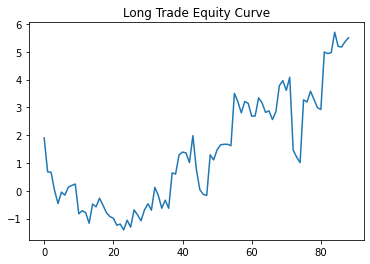

In [45]:
plt.plot( cum_long)
plt.title("Long Trade Equity Curve")


Text(0.5, 1.0, 'Short Trade Equity Curve')

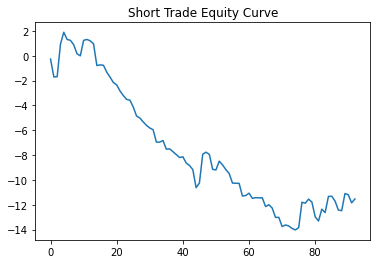

In [46]:
plt.plot( cum_short)
plt.title("Short Trade Equity Curve")


Text(0.5, 1.0, 'Equity_curve')

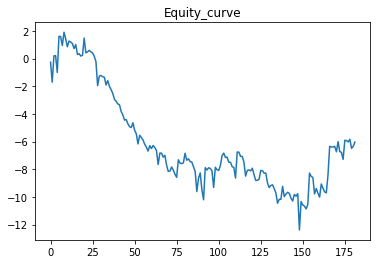

In [47]:
plt.plot(cum_p_l)
plt.title("Equity_curve")

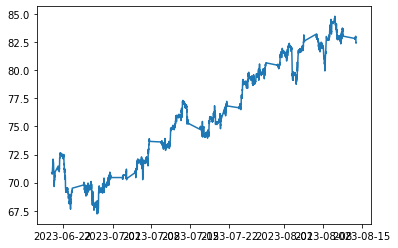

<Figure size 21600x7200 with 0 Axes>

In [48]:
plt.plot(data["Close"])
plt.figure(figsize=(300,100))
plt.show()

In [50]:
final

{'number of trades': 182,
 ' number of short trades': 93,
 ' number of long trades': 89,
 ' number of winning long trades': 40,
 ' number of loosing long trades': 49,
 ' number of winning short trades': 29,
 ' number of loosing short trades': 64,
 'Total win trades': 69,
 ' Total loose trades': 113,
 'hit ratio': 0.3791208791208791,
 'profit in long trade': 22.290008544921875,
 ' profit in short trade': 15.8499755859375,
 ' loss in long trade': -16.790000915527344,
 ' loss in short trade': -27.39006805419922,
 'total profit': 38.139984130859375,
 'total loss': -44.18006896972656,
 'net profit': -6.0400848388671875,
 'maximum_drawback': -2.6200027465820312,
 'time period': Timedelta('54 days 23:45:00')}